<a href="https://colab.research.google.com/github/bebechien/gemma/blob/main/How_to_Fine_tuning_Gemma_Random_Japanese_Movie_Titles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# How to Fine-tuning Gemma: Best Practices

To illustrate fine-tuning the model for a specific task, let's consider the example of generating a random Japanese title based on a user's instruction such as "Write a title". To make this possible, we curated a manageable dataset that could be manually processed. This approach is feasible because Gemma 2 has prior knowledge of general Japanese language patterns, enabling it to adapt to this specific task effectively.

## What is Fine-tuning

In the first place, you have to understand what is fine-tuning. It's a specialized form of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). It involves taking a pre-trained language model - one that has already been exposed to a vast corpus of text data and learned the general patterns and structures of language - and further training it on a smaller, more specific dataset. This additional training allows the model to adapt and refine its knowledge, making it better suited for a particular task or domain.

Imagine you are a skilled gamer who excels at various genres, from action-adventures to strategy games. Fine-tuning is akin to taking you and having you focus intensely on mastering a specific game, like a complex real-time strategy (RTS) title. You already possess a strong foundation of gaming skills and knowledge, but the dedicated practice and study within the RTS genre sharpens your tactics, understanding of game mechanics, and overall proficiency within that particular realm.

Similarly, pre-trained language models have a broad understanding of language, but fine-tuning helps them specialize. By exposing them to a curated dataset relevant to your desired application, you guide the model to learn the nuances and intricacies specific to that domain. It's like giving the model a crash course in the language of your chosen field, enabling it to perform tasks with greater accuracy and fluency.


## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environemnt variables

Set environement variables for ```KAGGLE_USERNAME``` and ```KAGGLE_KEY```.

In [1]:
import os
from google.colab import userdata, drive

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Mounting gDrive for to store artifacts
#drive.mount("/content/drive")

### Install dependencies

Install Keras and KerasNLP

In [2]:
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 128
num_data_limit = 100
lora_name = "my_lora"
lora_rank = 4
lr_value = 1e-3
train_epoch = 5
model_id = "gemma2_instruct_2b_en"

## Load Model

**Why Fine-tuning?**

Before embarking on fine-tuning, it's crucial to evaluate if its benefits align with the specific requirements of your application. Fine-tuning involves meticulous data preparation and extensive training, making it an arduous process. Therefore, it's essential to assess whether the potential gains justify the significant effort required.

**Try "Prompt Engineering" first.**

Would you like to enable Gemma's multilingual capabilities?
Please note that Gemma 2 already has some multilingual capabilities. Here's the example output from Gemma 2 2B instruction-tuned model.

Do you wish to adjust the tone or writing style?
Gemma 2 might be familiar with the writing style you have in mind. Here's another output from the same model.

In [3]:
import keras
import keras_nlp

import time

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()

# inference before fine-tuning
text_gen("Translate the text below to Japanese.\n\"Hi, how can I get to the Tokyo museum?\"")
text_gen("Speak like a pirate. Teach me why the earth is flat.")
text_gen("Write a title")
text_gen("Write a poem")


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
Translate the text below to Japanese.
"Hi, how can I get to the Tokyo museum?"<end_of_turn>
<start_of_turn>model
こんにちは、東京博物館はどこへ行くのが良いですか？ 

Here's a breakdown:

* **こんにちは** - Hello
* **どこへ行くのが良いですか** -  What's the best way to get there? (formal)
* **東京博物館** - Tokyo Museum


Let me know if you'd like me to translate any other phrases! 
<end_of_turn>
TOTAL TIME ELAPSED: 22.55s

Gemma output:
<start_of_turn>user
Speak like a pirate. Teach me why the earth is flat.<end_of_turn>
<start_of_turn>model
Ahoy, matey! Ye be wantin' to know 'bout the Earth, eh? Shiver me timbers, ye be lookin' at a tale spun by landlubbers! 

The Earth be no flat sheet o' parchment, but a grand ol' sphere, like a giant, bountiful treasure chest! 

Here's why ye can't be fooled by the scurvy tales:

* **The horizon be a curve, not a straight line:**  When ye look out to sea,
TOTAL TIME ELAPSED: 4.91s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>mod

## Tokenizer designed with multilingual in mind

Another important thing is the tokenizer.

Gemma tokenizer is based on [SentencePiece](https://github.com/google/sentencepiece). The size of the vocabulary is predetermined before training. SentencePiece then learns the optimal subword segmentation based on the chosen vocabulary size and the training data. Gemma's large 256k vocabulary allows it to handle diverse text inputs and potentially improve performance on various tasks, e.g. handling multilingual text inputs.

(example text: “Hi, Nice to meet you. The weather is really nice today.”)

In [4]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
import jax

def detoken(tokens):
  print(tokens)
  for x in tokens:
    word = tokenizer.detokenize(jax.numpy.array([x]))
    print(f"{x:6} -> {word}")

detoken(tokenizer("こんにちは。初めまして。今日は本当にいい天気ですね。"))

[ 32789 235362 147035  60914 235362  40574  35752  10598 106577  14088
 235362]
 32789 -> こんにちは
235362 -> 。
147035 -> 初め
 60914 -> まして
235362 -> 。
 40574 -> 今日は
 35752 -> 本当に
 10598 -> いい
106577 -> 天気
 14088 -> ですね
235362 -> 。


## Load Dataset

How many datasets do you need? You can start with relatively small number of datasets, approximately 10 to 20, those can have a significant impact on a model's behavior.

For improved the output quality, a target of around 200 total examples is recommended. Nevertheless, the amount of data required for tuning really depends on how much you want to influence the model's behavior. Our recommendation is to commence with a limited amount of data and gradually incorporate additional data into the training process until the desired behavior is achieved.

In [5]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

# example titles
data = [
    "星空の旅人",   # (Hoshizora no Tabibito) - Starry Sky Traveler
    "沈黙の剣",     # (Chinmoku no Tsurugi) - Silent Sword
    "風の歌",       # (Kaze no Uta) - Song of the Wind
    "永遠の炎",     # (Eien no Honoo) - Eternal Flame
    "幻の都市",     # (Maboroshi no Toshi) - Phantom City
    "深海の秘密",   # (Shinkai no Himitsu) - Secret of the Deep Sea
    "運命の出会い", # (Unmei no Deai) - Destined Encounter
    "禁断の果実",   # (Kindan no Kajitsu) - Forbidden Fruit
    "影の狩人",     # (Kage no Karyudo) - Shadow Hunter
    "希望の光",     # (Kibou no Hikari) - Light of Hope
    "蒼い海の伝説", # (Aoi Umi no Densetsu)
    "黒曜石の涙",   # (Kokuyouseki no Namida) - Obsidian Tears
    "砂漠の薔薇",   # (Sabaku no Bara) - Desert Rose
    "黄金の鍵",     # (Ougon no Kagi) - Golden Key
    "嵐の夜に",     # (Arashi no Yoru ni) - On a Stormy Night
]

train = []

for x in data:
  item = f"<start_of_turn>user\nWrite a title<end_of_turn>\n<start_of_turn>model\n{x}<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print(train[1])
print(train[2])

15
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
星空の旅人<end_of_turn>
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
沈黙の剣<end_of_turn>
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
風の歌<end_of_turn>


See below example code, using HF datasets, if your datasets are much bigger.

In [ ]:
# Example of using HF datasets
# Replying to request emails that a bakery business might get, in Korean
# The given prompt means "Please write an email reply with below."
'''
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

# prompt structure
# <start_of_turn>user
# 다음에 대한 이메일 답장을 작성해줘.
# "{EMAIL CONTENT FROM THE CUSTOMER}"
# <end_of_turn>
# <start_of_turn>model
# {MODEL ANSWER}<end_of_turn>

# input, output
from datasets import load_dataset
ds = load_dataset(
    "bebechien/korean_cake_boss",
    split="train",
)
print(ds)
data = ds.with_format("np", columns=["input", "output"], output_all_columns=False)
train = []

for x in data:
  item = f"<start_of_turn>user\n다음에 대한 이메일 답장을 작성해줘.\n\"{x['input']}\"<end_of_turn>\n<start_of_turn>model\n{x['output']}<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print(train[1])
print(train[2])
'''

In the context of a small dataset, the primary concern is that the model may prioritize memorizing specific examples rather than generalizing well to new and unobserved data. This limitation highlights the importance of utilizing a larger dataset during fine-tuning, as it enhances the model's ability to capture broader patterns and relationships.

## LoRA Fine-tuning

Train your model with lower ranks and evaluate the performance improvemnet on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [6]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly. In practice, we recommend beginning with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation.

To monitor the learning progress, we will evaluate the model at the end of each epoch and save the all lora weights.

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 1.4640 - sparse_categorical_accuracy: 0.1965
Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
<end_of_turn>
TOTAL TIME ELAPSED: 19.54s

Gemma output:
<start_of_turn>user
Write a poem<end_of_turn>
<start_of_turn>model
The wind whispers secrets through the trees,
A rustling song, carried on the breeze.
Sunlight dances, dappled and bright,
Painting shadows in the fading light.

A lone bird sings, a melody sweet,
A gentle tune, a heart's soft beat.
The world is still, a moment held,
A tranquil peace, a story spelled.

The river flows, a silver thread,
Through fields of green, where dreams are bred.
A gentle ripple, a whispered sigh,
As nature sleeps beneath the sky. 


<end_of_turn>
TOTAL TIME ELAPSED: 6.99s
8/8 ━━━━━━━━━━━━━━━━━━━━ 149s 14s/step - loss: 1.4399 - sparse_categorical_accuracy: 0.2046
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - loss: 0.5939 - sparse_categorical_accuracy: 0.5364
Gemm

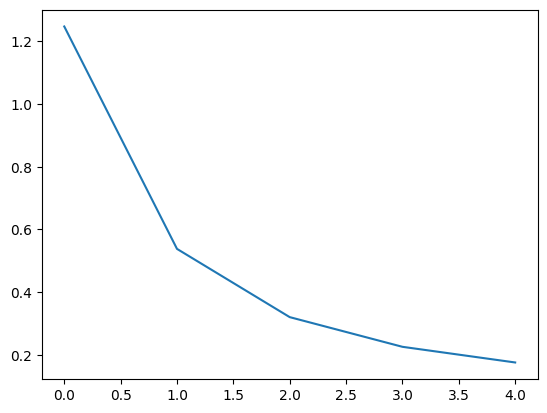

In [7]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #model_name = f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    #gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("Write a title")
    text_gen("Write a poem")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

Note that the model began to grasp our intent more effectively from Epoch #3 onwards.

To compare and contrast, we utlized the "Write a poem" prompt. Interestingly, in Epoch #4, the model began to generate a simple Japanese Title instead of the poem, in response to that prompt. This shift indicates a strong influence of our training dataset on the model's behavior. However, depending on your application, such a significat change might not be desirable. In such cases, Epoch #3 would be a more suitable choice.

## Load LoRA

Use the code below if you shared LoRA weights. It's much more lightweight than the model files themselves - for instance, a LoRA rank 4 weights file for a 10gb model might only be on the order of a few megabytes, easily shared over email.

In [ ]:
# Example Code for Load LoRA
'''
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
# Use the same LoRA rank that you trained
gemma_lm.backbone.enable_lora(rank=4)

# Load pre-trained LoRA weights
gemma_lm.backbone.load_lora_weights(f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{train_epoch}.lora.h5")
'''

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

In [8]:
gemma_lm.compile(sampler="top_k")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")


Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
蒼の海を歩く<end_of_turn>
TOTAL TIME ELAPSED: 21.10s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
蒼い海を旅する<end_of_turn>
TOTAL TIME ELAPSED: 0.66s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
蒼い海の伝説<end_of_turn>
TOTAL TIME ELAPSED: 0.54s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
黒曜石の涙<end_of_turn>
TOTAL TIME ELAPSED: 0.60s

Gemma output:
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
深海の秘密<end_of_turn>
TOTAL TIME ELAPSED: 0.56s


Try a slight different prompts

In [9]:
text_gen("Write a music title")
text_gen("Write a poem title")
text_gen("Write a blog title")
text_gen("Write a movie title")
text_gen("Write a novel title")


Gemma output:
<start_of_turn>user
Write a music title<end_of_turn>
<start_of_turn>model
風の歌<end_of_turn>
TOTAL TIME ELAPSED: 0.43s

Gemma output:
<start_of_turn>user
Write a poem title<end_of_turn>
<start_of_turn>model
深海の迷宮<end_of_turn>
TOTAL TIME ELAPSED: 0.60s

Gemma output:
<start_of_turn>user
Write a blog title<end_of_turn>
<start_of_turn>model
運命の出会い<end_of_turn>
TOTAL TIME ELAPSED: 0.49s

Gemma output:
<start_of_turn>user
Write a movie title<end_of_turn>
<start_of_turn>model
黒曜石の涙<end_of_turn>
TOTAL TIME ELAPSED: 0.61s

Gemma output:
<start_of_turn>user
Write a novel title<end_of_turn>
<start_of_turn>model
黒曜石の瞳<end_of_turn>
TOTAL TIME ELAPSED: 0.61s
